In [1]:
import torch
import yaml 
import matplotlib.pyplot as plt
import torch.nn.functional as F
import os
import numpy as np

from model.PairVAE import PairVAE
from model.pl_PairVAE import PlPairVAE
from dataset.datasetPairH5 import PairHDF5Dataset


/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Params

In [2]:
dossier = "lightning_logs/version_78887/checkpoints/"
fichiers = [f for f in os.listdir(dossier) if os.path.isfile(os.path.join(dossier, f))]

print(fichiers)

FileNotFoundError: [Errno 2] No such file or directory: 'lightning_logs/version_78887/checkpoints/'

In [2]:
path_checkpoint = "lightning_logs/version_78887/checkpoints/epoch=1-step=2446.ckpt"
path_config = "model/pair_vae2.yaml"

In [3]:
array_valid = np.load("lightning_logs/version_78887/val_indices.npy")
array_valid

FileNotFoundError: [Errno 2] No such file or directory: 'lightning_logs/version_78887/val_indices.npy'

In [ ]:
array_train = np.load("lightning_logs/version_78887/train_indices.npy")
array_train

In [3]:
with open(path_config, 'r') as file:
    config = yaml.safe_load(file)

In [4]:
config

{'dataset': {'hdf5_file': 'data/pair_saxs_les_closest_of_concentration.h5',
  'metadata_filters': {'material': ['ag']},
  'requested_metadata': ['shape', 'material'],
  'conversion_dict_path': 'data/conversion_dict_all.json',
  'sample_frac': 1.0,
  'transform': {'y_saxs': {'LogTransformer': {},
    'MinMaxNormalizer': {},
    'PaddingTransformer': {'pad_size': 80, 'value': 0}},
   'y_les': {'MinMaxNormalizer': {},
    'PaddingTransformer': {'pad_size': 80, 'value': 0}},
   'q_les': {'PaddingTransformer': {'pad_size': 80, 'value': 0}},
   'q_saxs': {'PaddingTransformer': {'pad_size': 80, 'value': 0}}}},
 'training': {'num_gpus': 1,
  'num_nodes': 1,
  'num_epochs': 50,
  'patience': 10,
  'batch_size': 32,
  'num_workers': 3,
  'lambda_param': 0.0001,
  'weight_latent_similarity': 0.005,
  'weight_saxs2saxs': 0.1,
  'weight_saxs2les': 1,
  'weight_les2les': 0.1,
  'weight_les2saxs': 1,
  'max_lr': 0.0001,
  'T_max': 25,
  'eta_min': 1e-05},
 'model': {'VAE_SAXS': {'vae_class': 'Customi

# Model

In [5]:
model = PlPairVAE(config)

INIT VAE SAXS
{'dilation': 1, 'down_channels': [16, 32, 64, 128], 'in_channels': 1, 'input_dim': 80, 'latent_dim': 64, 'output_channels': 1, 'strat': 'y', 'up_channels': [128, 64, 32, 16]}
VAE Architecture:
	Input Dimension: 80
	Latent Dimension: 64
	In Channels: 1
	Down Channels: [16, 32, 64, 128]
	Up Channels: [128, 64, 32, 16]
	Output Channels: 1
	Flattened Size: 320
	Encoder Architecture: Sequential(
  (0): Conv1d(1, 16, kernel_size=(3,), stride=(2,), padding=(1,))
  (1): ReLU()
  (2): Conv1d(16, 16, kernel_size=(3,), stride=(1,), padding=(1,))
  (3): ReLU()
  (4): Conv1d(16, 32, kernel_size=(3,), stride=(2,), padding=(1,))
  (5): ReLU()
  (6): Conv1d(32, 32, kernel_size=(3,), stride=(1,), padding=(1,))
  (7): ReLU()
  (8): Conv1d(32, 64, kernel_size=(3,), stride=(2,), padding=(1,))
  (9): ReLU()
  (10): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (11): ReLU()
  (12): Conv1d(64, 128, kernel_size=(3,), stride=(2,), padding=(1,))
  (13): ReLU()
  (14): Conv1d(128, 1

In [11]:
checkpoint = torch.load(path_checkpoint, map_location=torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
model.load_state_dict(checkpoint['state_dict'])

FileNotFoundError: [Errno 2] No such file or directory: 'lightning_logs/version_78887/checkpoints/epoch=1-step=2446.ckpt'

# Dataset

In [6]:
dataset = PairHDF5Dataset(
hdf5_file = config["dataset"]["hdf5_file"],
metadata_filters = config["dataset"]["metadata_filters"],
conversion_dict_path = config["dataset"]["conversion_dict_path"],
sample_frac = config["dataset"]["sample_frac"],
transform =  config["dataset"]["transform"],
requested_metadata =  config["dataset"]["requested_metadata"],
)
print("========================================")

Applying filters: 100%|██████████| 1/1 [00:00<00:00,  2.51it/s]


╒══════════════════════════════════════════════╕
│ Dataset Initialization Info                 │
╞══════════════════════════════════════════════╡
│ File: data/pair_saxs_les_closest_of_concentration.h5 │
│ Total samples: 97841                      │
│ Samples filtered: 48907                   │
│ Requested fraction: 1.0                    │
│ Fractioned samples: 48907                  │
│ Requested metadata: 2                      │


# Plot

In [7]:
def plot(idx_sample):
    one_sample = dataset[idx_sample]
    print(one_sample["metadata"])
    
    one_sample = {k:v.unsqueeze(0) if "data_" in k else v for k,v in one_sample.items()}
    dict_output = model(one_sample)

    mse_values = {}
    for recon_key in ["recon_les","recon_saxs2les"]:
        mse_values[recon_key] = F.mse_loss(one_sample["data_y_les"], dict_output[recon_key]).item()
    
    for recon_key in ["recon_saxs","recon_les2saxs"]:
        mse_values[recon_key] = F.mse_loss(one_sample["data_y_saxs"], dict_output[recon_key]).item()

    dict_print = dict_output
    dict_print["y_saxs"] = one_sample["data_y_saxs"]
    dict_print["y_les"] = one_sample["data_y_les"]
    dict_print.pop("z_les")
    dict_print.pop("z_saxs")
        
    dict_saxs = {k:v for k,v in dict_print.items() if k.endswith("saxs")}
    dict_les = {k:v for k,v in dict_print.items() if k.endswith("les")}

    plt.figure(figsize=(5, 3))
    for i, (key, tensor) in enumerate(dict_saxs.items(), 1):
        if key != "y_saxs":
            label = f"{key} with MSE : {round(mse_values[key],5)}"
        else :
            label = key
        plt.plot(tensor.detach().numpy().flatten(), label=label)
        plt.title("SAXS")
        plt.legend()
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(5, 3))
    for i, (key, tensor) in enumerate(dict_les.items(), 1):
        if key != "y_les":
            label = f"{key} with MSE : {round(mse_values[key],5)}"
        else :
            label = key
        plt.plot(tensor.detach().numpy().flatten(), label=label)
        plt.title("LES")
        plt.legend()
    plt.tight_layout()
    plt.show()

## Train

{'shape': tensor(0., dtype=torch.float64), 'material': tensor(3., dtype=torch.float64)}


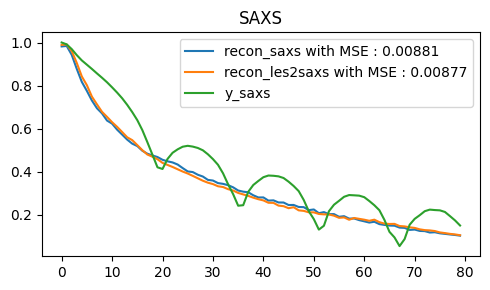

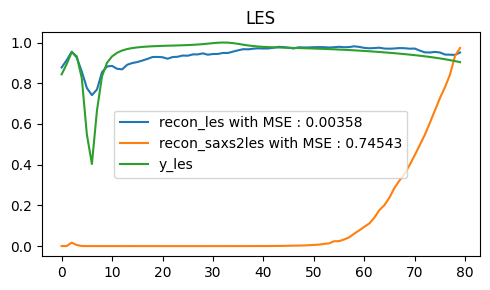

In [17]:
plot(487)

In [9]:
plot(array_train[4944])

NameError: name 'array_train' is not defined

## Valid

{'shape': tensor(0., dtype=torch.float64), 'material': tensor(3., dtype=torch.float64)}


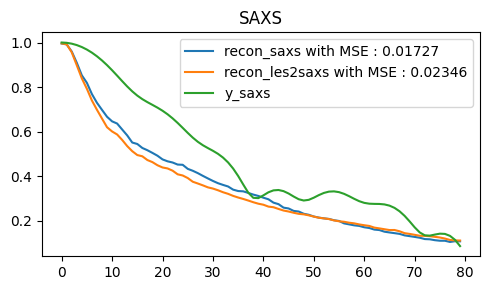

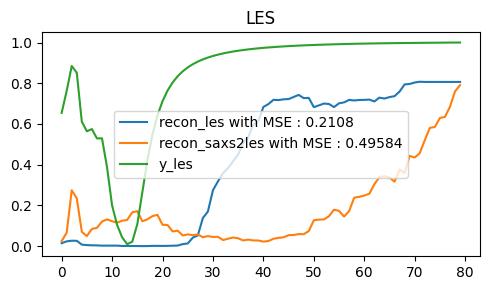

In [17]:
plot(array_valid[8224])

{'shape': tensor(0., dtype=torch.float64), 'material': tensor(3., dtype=torch.float64)}


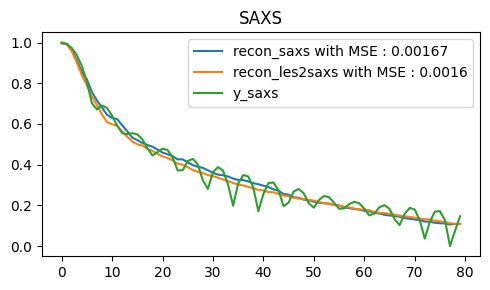

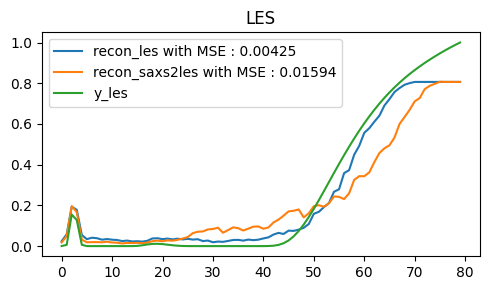

In [18]:
plot(array_valid[45])

{'shape': tensor(0., dtype=torch.float64), 'material': tensor(3., dtype=torch.float64)}


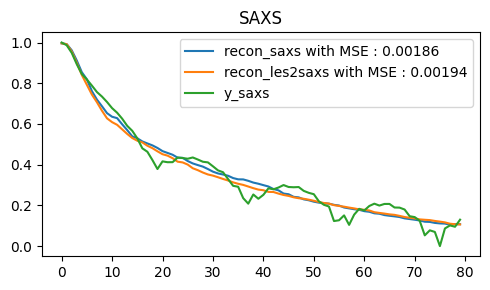

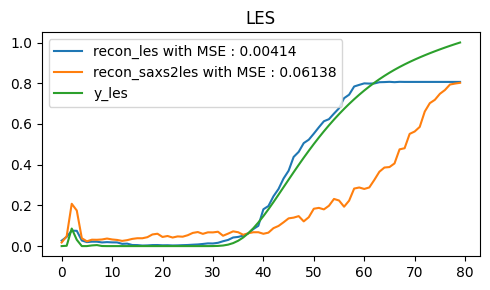

In [19]:
plot(array_valid[111])

{'shape': tensor(0., dtype=torch.float64), 'material': tensor(3., dtype=torch.float64)}


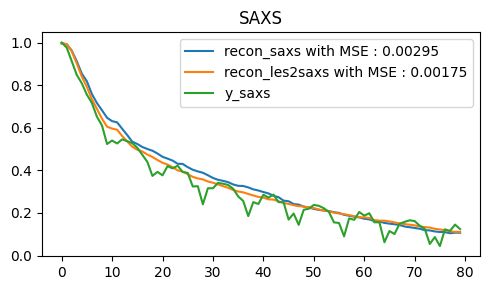

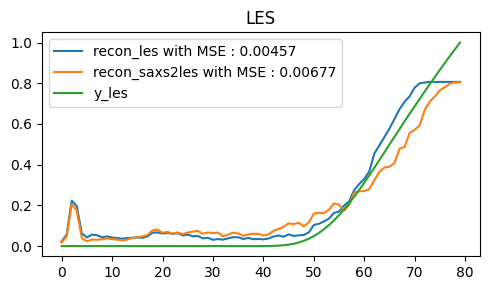

In [20]:
plot(array_valid[32])

{'shape': tensor(0., dtype=torch.float64), 'material': tensor(3., dtype=torch.float64)}


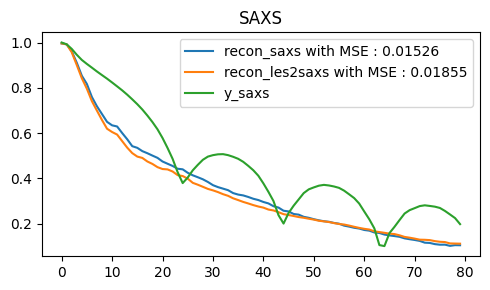

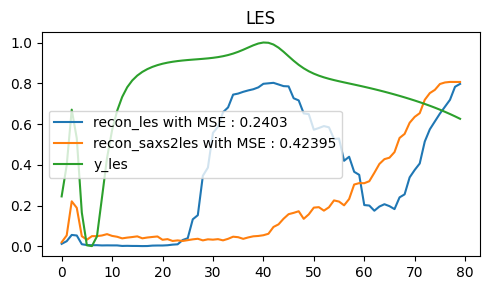

In [21]:
plot(array_valid[1215])